## Enviroment settings

In [83]:
import arcpy
import os
from arcgis.features import GeoAccessor
from arcgis import GIS
from arcgis.widgets import MapView
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats
from ipywidgets import *

# notebook settings
%matplotlib inline

# set workspace
arcpy.env.workspace = r'C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb'

# set overwriteOutput to True
arcpy.env.overwriteOutput = True 

# prevent outputs to map
arcpy.addOutputsToMap = False

# data paths used for analysis
ufo_data = r'C:\Users\JGrov\Desktop\UFO_Sightings\Data\ufo_sightings.csv'

airport_data = r'C:\Users\JGrov\Desktop\UFO_Sightings\Data\us-airports.csv'

pop_data = r'C:\Users\JGrov\Desktop\UFO_Sightings\Data\co-est2020.csv'

county_data = r'C:\Users\JGrov\Desktop\UFO_Sightings\Data\cb_2018_us_county_20m.shp'

fips_data = r'C:\Users\JGrov\Desktop\UFO_Sightings\Data\state_fips.csv'

# create list paths and labels
data_paths =[(arcpy.env.workspace, 'geodatabase'),
             (ufo_data, 'UFO data'),
             (airport_data, 'airport data'),
             (pop_data, 'population data'),
             (county_data, 'county data'),
             (fips_data, 'FIPS data')]

# loop through data path and check to see if workspace exists
for path, lable in data_paths:
    path_exist = os.path.exists(f'{path}')
    if path_exist == True:
        print(f'SUCCESS: {lable} located')
    else:
        print(f'ERROR: {path} does not exist')

SUCCESS: geodatabase located
SUCCESS: UFO data located
SUCCESS: airport data located
SUCCESS: population data located
SUCCESS: county data located
SUCCESS: FIPS data located


## Functions

In [84]:
def sdf_to_featureclass(tuple_df_outname):
    for df, outname in tuple_df_outname:
        # creates export path
        export = f'{arcpy.env.workspace}\\{outname}'
        # create a featureclass
        df.spatial.to_featureclass(location=export)
        print(f'Success! Featureclass located at {export}')

# performs nearest neighbor analysis        
def nearest_neighbor(point_data):
    # creates variable to run AverageNearestNeighbor
    nn_output = arcpy.stats.AverageNearestNeighbor(point_data, 'EUCLIDEAN_DISTANCE', 'GENERATE_REPORT')
    # Create list of Average Nearest Neighbor output values by splitting the result object
    print(f'The nearest neighbor index is: {nn_output[0]}')
    print(f'The z-score of the nearest neighbor index is: {nn_output[1]}')
    print(f'The p-value of the nearest neighbor index is: {nn_output[2]}')
    print(f'The expected mean distance is: {nn_output[3]}')
    print(f'The observed mean distance is: {nn_output[4]}')
    print(f'The path of the HTML report: {nn_output[5]}')
    # change data type of z-score to float
    z_score = float(nn_output[1])
    # determine if ufo sightings are statistically random, dispersed, or random
    if z_score < 1.65 and z_score > -1.65:
        print('\nThe UFO sightings are statistically random.')
    elif z_score > 1.65:
        print(f'\nGiven the z-score of {nn_output[1]}, UFO sightings are statistically dispersed.')
    elif z_score < -1.65:
        print(f'\nGiven the z-score of {nn_output[1]}, UFO sightings are statistically clustered.')
        
# performs spatial autocorrelation analysis using Morans Index
def morans_index(input_fc, input_field):
    # creates variable to run Morans I
    mi_output = arcpy.stats.SpatialAutocorrelation(Input_Feature_Class=input_fc, 
                                                   Input_Field=input_field, 
                                                   Generate_Report='GENERATE_REPORT', 
                                                   Conceptualization_of_Spatial_Relationships='INVERSE_DISTANCE', 
                                                   Distance_Method='EUCLIDEAN_DISTANCE', 
                                                   Standardization='ROW')
    # Create list of Average Nearest Neighbor output values by splitting the result object
    print(f'Moran\'s index value: {mi_output[0]}')
    print(f'The z-score of Moran\'s index is: {mi_output[1]}')
    print(f'The p-value of Moran\'s index is: {mi_output[2]}')
    # change data type of z-score to float
    z_score = float(mi_output[1])
    # determine if ufo sightings are statistically random, dispersed, or random
    if z_score < 1.65 and z_score > -1.65:
        print('\nThe counties with UFO sightings are statistically random.')
    elif z_score > 1.65:
        print(f'\nGiven the z-score of {mi_output[1]}, the counties with UFO sightings are statistically clustered.')
    elif z_score < -1.65:
        print(f'\nGiven the z-score of {mi_output[1]}, the counties with UFO sightings are statistically dispersed.')

print('Functions ready to go!')

Functions ready to go!


## Filter and export data to a featureclass

### UFO sighting data

In [85]:
# import .csv into a dataframe
df_ufo = pd.read_csv(ufo_data)

# change latitude to numeric value to import into a spatial dataframe
df_ufo['latitude'] = pd.to_numeric(df_ufo['latitude'], errors='coerce')

# create a spatial dataframe so it can be exported to a shapefile
sdf_ufo = GeoAccessor.from_xy(df=df_ufo, 
                              x_column='longitude', 
                              y_column='latitude')

# list of items to filter out of dataframe
remove = ['hi', 'ak', 'pr']

# filters dataframe to get only those points in the lower 48
sdf_ufo48 = sdf_ufo[(sdf_ufo['country'] == 'us') & (~sdf_ufo['state'].isin(remove))]

# drop duplicate coordinates from dataframe
sdf_ufo48_dropped = sdf_ufo48.drop_duplicates(subset=['latitude', 'longitude'], keep='first').copy()

# view unique values 
print(f'There were {sdf_ufo48.shape[0] - sdf_ufo48_dropped.shape[0]} duplicate coordinates dropped out of {sdf_ufo48.shape[0]} entries.', '\n')
print('States:\n', sdf_ufo48_dropped['state'].unique(), '\n')
print('Countries:\n', sdf_ufo48_dropped['country'].unique(), '\n')

# check the info the spatial dataframe
sdf_ufo48_dropped.info()

sys:1: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.


There were 51630 duplicate coordinates dropped out of 64508 entries. 

States:
 ['tx' 'tn' 'ct' 'al' 'fl' 'ca' 'nc' 'ny' 'ky' 'mi' 'ma' 'ks' 'sc' 'wa'
 'co' 'nh' 'wi' 'me' 'ga' 'pa' 'il' 'ar' 'mo' 'oh' 'in' 'az' 'mn' 'nv'
 'ne' 'or' 'ia' 'va' 'id' 'nm' 'nj' 'wv' 'ok' 'ri' 'vt' 'la' 'ms' 'ut'
 'md' 'mt' 'wy' 'sd' 'de' 'nd' 'dc'] 

Countries:
 ['us'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12878 entries, 0 to 80276
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   datetime              12878 non-null  object  
 1   city                  12878 non-null  object  
 2   state                 12878 non-null  object  
 3   country               12878 non-null  object  
 4   shape                 12566 non-null  object  
 5   duration (seconds)    12878 non-null  object  
 6   duration (hours/min)  12878 non-null  object  
 7   comments              12876 non-null  object  
 8   date posted  

In [86]:
sdf_ufo48_dropped.sample(5)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,SHAPE
8515,11/1/2011 21:00,goldsboro,nc,us,fireball,30,about 30 seconds,I saw 4 balls of fire floating through the nig...,2/3/2012,35.3847,-77.9931,"{""spatialReference"": {""wkid"": 4326}, ""x"": -77...."
5253,10/29/2001 22:00,clarendon,ny,us,sphere,300,5 min.,glowing sphere and small sphere seen&#44 thoug...,5/24/2005,43.1933,-78.0650,"{""spatialReference"": {""wkid"": 4326}, ""x"": -78...."
67129,8/17/1995 19:45,south park,wa,us,NaN,90.0,90 sec.,Man witnesses &quot;white spot&quot; flying in...,11/2/1999,47.5267,-122.3133,"{""spatialReference"": {""wkid"": 4326}, ""x"": -122..."
25122,1/7/2010 19:34,west boylston,ma,us,light,1,approx. 1 sec.,Bright Florissant-green&#44 circular light arc...,2/14/2010,42.3917,-71.7042,"{""spatialReference"": {""wkid"": 4326}, ""x"": -71...."
33768,3/27/2009 21:40,shelly,mn,us,other,1200,20 minutes,Saw a big blue light and a smaller red light d...,4/14/2009,47.4581,-96.8181,"{""spatialReference"": {""wkid"": 4326}, ""x"": -96...."


### U.S. airport data

In [87]:
# creates path for airport data
airport_data = r'C:\Users\JGrov\Desktop\Final_Project\UFO\Data\us-airports.csv'

# reads airport data into a csv
df_airports = pd.read_csv(airport_data)

# list of fields for to_numeric to be applied to
cols = ['latitude_deg', 'longitude_deg']

# apply the to_numeric function to items in cols list
df_airports[cols] = df_airports[cols].apply(pd.to_numeric, errors='coerce')

# create a spatial dataframe so it can be exported to a shapefile
sdf_airports = GeoAccessor.from_xy(df=df_airports, 
                                   x_column='longitude_deg', 
                                   y_column='latitude_deg')

# create list of items to remove from selection
remove = ['#adm1 +code +local', 'AK', 'HI', '340806', '339756', '320934']

# filter out airports not in the lower 48 and filter out wrong coordinates by id in the remove list
sdf_airports48 = sdf_airports[(~sdf_airports['local_region'].isin(remove)) & (~sdf_airports['id'].isin(remove))].copy()

# view unique values 
print('States:\n', sdf_airports48['local_region'].unique(), '\n')

# check the info the spatial dataframe
sdf_airports.info()

States:
 ['CA' 'IL' 'NY' 'GA' 'NJ' 'TX' 'NV' 'CO' 'FL' 'DC' 'AZ' 'MA' 'WA' 'PA'
 'NC' 'MI' 'MN' 'UT' 'MD' 'MO' 'OR' 'LA' 'KY' 'TN' 'OH' 'IN' 'NM' 'WI'
 'CT' 'OK' 'NE' 'RI' 'VA' 'SC' 'AL' 'ID' 'KS' 'IA' 'AR' 'ME' 'NH' 'VT'
 'SD' 'WY' 'MT' 'ND' 'MS' 'WV' 'DE'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28025 entries, 0 to 28024
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 28025 non-null  object  
 1   ident              28025 non-null  object  
 2   type               28025 non-null  object  
 3   name               28025 non-null  object  
 4   latitude_deg       28024 non-null  float64 
 5   longitude_deg      28024 non-null  float64 
 6   elevation_ft       26039 non-null  object  
 7   continent          1 non-null      object  
 8   country_name       28025 non-null  object  
 9   iso_country        28025 non-null  object  
 10  region_name        28025 non-null  ob

In [88]:
sdf_airports.sample(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,region_name,iso_region,local_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated,SHAPE
22491,324949,99FA,heliport,Halifax Hospital Emergency Helostop,28.958386,-81.255586,65,NaN,United States,US,Florida,US-FL,FL,Deltona,0,99FA,NaN,99FA,NaN,NaN,NaN,0,2017-09-16T07:28:16+00:00,"{""spatialReference"": {""wkid"": 4326}, ""x"": -81...."
14151,21979,ME56,closed,Kimberly Airport,44.069199,-69.305298,255,NaN,United States,US,Maine,US-ME,ME,Waldoboro,0,ME56,NaN,ME56,NaN,NaN,NaN,50,2020-09-24T11:41:54+00:00,"{""spatialReference"": {""wkid"": 4326}, ""x"": -69...."
27156,325115,AA09,small_airport,Busch Creek Airport,62.477502,-147.774722,3984,NaN,United States,US,Alaska,US-AK,AK,Talkeetna,0,AA09,NaN,AA09,NaN,NaN,NaN,0,2017-10-06T22:26:27+00:00,"{""spatialReference"": {""wkid"": 4326}, ""x"": -147..."
22036,335995,US-1569,closed,Philmont Scout Ranch Landing Strip,36.488200,-104.948090,NaN,NaN,United States,US,New Mexico,US-NM,NM,Cimarron,0,NaN,NaN,NaN,NaN,NaN,NaN,0,2020-09-23T13:49:49+00:00,"{""spatialReference"": {""wkid"": 4326}, ""x"": -104..."
10471,11957,53IL,closed,Clapper Airport,40.152802,-88.516701,710,NaN,United States,US,Illinois,US-IL,IL,Mansfield,0,NaN,NaN,NaN,NaN,NaN,53IL,50,2021-07-25T14:13:26+00:00,"{""spatialReference"": {""wkid"": 4326}, ""x"": -88...."


In [89]:
# create a list of tuples with dataframe and output name
output = [(sdf_ufo48_dropped, 'ufo_sightings_lower48'),
          (sdf_airports48, 'us_airports_lower48')]

# run function sdf_to_featureclass
sdf_to_featureclass(output)

Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\ufo_sightings_lower48
Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\us_airports_lower48


## Spatial analysis

### Run nearest neighbor analysis on entire ufo sightings dataset

In [90]:
nearest_neighbor('ufo_sightings_lower48')

The nearest neighbor index is: 0.677074
The z-score of the nearest neighbor index is: -70.106486
The p-value of the nearest neighbor index is: 0
The expected mean distance is: 16052.037957
The observed mean distance is: 10868.416425
The path of the HTML report: C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\NearestNeighbor_Result_816_6256_6.html

Given the z-score of -70.106486, UFO sightings are statistically clustered.


### Determine ufo sightings distance from airports

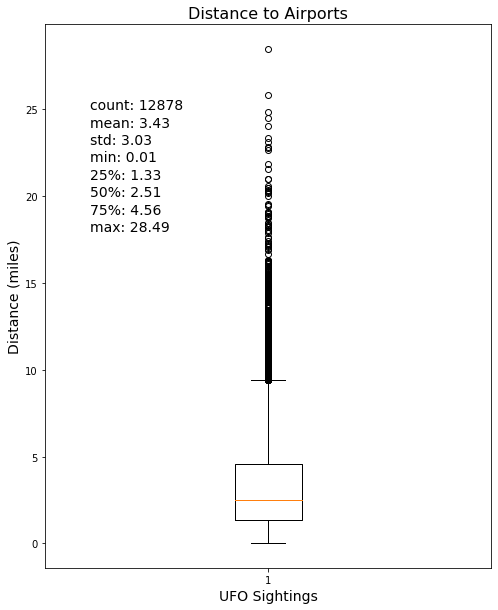

In [91]:
# retreive point distances between ufo sightings and airports
ufo_points = 'ufo_sightings_lower48'
airport_points = 'us_airports_lower48'
table_name = 'ufo_airport_distance'

# generate table that shows nearest distance between airports and ufo_sightings
arcpy.analysis.GenerateNearTable(in_features=ufo_points, 
                                 near_features=airport_points, 
                                 out_table=table_name,
                                 search_radius="",
                                 location="",
                                 angle="",
                                 closest="",
                                 closest_count="",
                                 method='GEODESIC')

arcpy.management.AddField(in_table=table_name, 
                          field_name='miles', 
                          field_type='FLOAT',
                          field_precision=2)

# create update cursor for feature class 
with arcpy.da.UpdateCursor(table_name, ['NEAR_DIST', 'miles']) as cursor:
    # for each row, miles = NEAR_DIST * 0.000621
    for row in cursor:
        # convert meters to miles
        row[1] = row[0] * 0.000621
        # update the cursor 
        cursor.updateRow(row)

# create spatial dataframe to plot
sdf_distance = pd.DataFrame.spatial.from_table('ufo_airport_distance')

# create figure
fig, ax = plt.subplots(1,1, facecolor=('#FFFFFF'), figsize=(8,10))

# plot boxplot
plt.boxplot(sdf_distance['miles'])
# create y label
ax.set_title('Distance to Airports', fontsize=16)
# create x label
ax.set_xlabel('UFO Sightings', fontsize=14)
# create title
ax.set_ylabel('Distance (miles)', fontsize=14)

# store describe and font size in a variable
desc = sdf_distance['miles'].describe()
fntsize = 14

# create text to describe statistics on plot
plt.text(.6,25, f'count: {int(desc[0])}', fontsize=fntsize)
plt.text(.6,24, f'mean: {round(desc[1], 2)}', fontsize=fntsize)
plt.text(.6,23, f'std: {round(desc[2], 2)}', fontsize=fntsize)
plt.text(.6,22, f'min: {round(desc[3], 2)}', fontsize=fntsize)
plt.text(.6,21, f'25%: {round(desc[4], 2)}', fontsize=fntsize)
plt.text(.6,20, f'50%: {round(desc[5], 2)}', fontsize=fntsize)
plt.text(.6,19, f'75%: {round(desc[6], 2)}', fontsize=fntsize)
plt.text(.6,18, f'max: {round(desc[7], 2)}', fontsize=fntsize)

# show plot
plt.show()

### Select outliers which have a distance outside 3 standard deviations

In [92]:
# create id column to join distance 
sdf_ufo48_dropped['IN_FID'] = range(1, 1+len(sdf_ufo48_dropped))

# join both sdf_ufo48 and sdf_distance on 'IN_FID'
sdf_joined = sdf_ufo48_dropped.join(sdf_distance.set_index('IN_FID'), on='IN_FID').reset_index(drop=True)

# numpy sets absolute value (abs) and stats functions calls the zscore method on the miles column
z = np.abs(stats.zscore(sdf_joined['miles']))

# create a new dataframe where miles column has a z-score larger than 3
sdf_outliers = sdf_joined[(z > 3)]

# rename columns
sdf_outliers = sdf_outliers.rename(columns={'duration (seconds)': 'duration_sec',
                                            'shape': 'ufo_shape',
                                            'miles': 'airprt_dist_mi'})

# apply string formatting
sdf_outliers['city'] = sdf_outliers['city'].str.title()
sdf_outliers['state'] = sdf_outliers['state'].str.upper()

# change duration_sec to numeric value and set a int data type
sdf_outliers['duration_sec'] = pd.to_numeric(sdf_outliers['duration_sec'], errors='coerce')
sdf_outliers['duration_sec'] = sdf_outliers['duration_sec'].astype(int)

# round airprt_dist_mi column two decimals
sdf_outliers['airprt_dist_mi'] = sdf_outliers['airprt_dist_mi'].round(2)

# create datetime object
sdf_outliers['datetime'] = pd.to_datetime(sdf_outliers['datetime'], errors='coerce')
sdf_outliers['month'] = sdf_outliers['datetime'].dt.strftime('%b')
sdf_outliers['year'] = sdf_outliers['datetime'].dt.strftime('%Y')

# select columns of interest
sdf_outliers = sdf_outliers[['datetime', 'month', 'year', 'city', 'state', 'duration_sec', 'ufo_shape', 'comments', 'airprt_dist_mi','latitude', 'longitude', 'SHAPE']].copy()

print(f'There are {sdf_outliers.shape[0]} outliers selected out of {sdf_joined.shape[0]} points.')

sdf_outliers.head()

There are 243 outliers selected out of 12878 points.


,datetime,month,year,city,state,duration_sec,ufo_shape,comments,airprt_dist_mi,latitude,longitude,SHAPE
65,1999-10-10 21:00:00,Oct,1999,Rachel,NV,10800,light,Bright lights with incredible agility seen fro...,28.49,37.6447,-115.7428,"{""spatialReference"": {""wkid"": 4326}, ""x"": -115..."
129,2007-10-10 22:00:00,Oct,2007,Fleming,CO,600,circle,UFO SPOTTED&#44 FLEMING COLORADO,12.96,40.6800,-102.8389,"{""spatialReference"": {""wkid"": 4326}, ""x"": -102..."
135,2008-10-10 04:00:00,Oct,2008,Carlin,NV,600,disk,Ufo sighting in Carlin&#44 NV&#44 at the pilot...,18.02,40.7139,-116.1031,"{""spatialReference"": {""wkid"": 4326}, ""x"": -116..."
414,1993-10-01 20:00:00,Oct,1993,Pryor,MT,1800,light,Floating Light&#44 Like a Spotlight,17.10,45.4297,-108.5325,"{""spatialReference"": {""wkid"": 4326}, ""x"": -108..."
569,2008-10-01 20:00:00,Oct,2008,Glenrock,WY,1200,unknown,Stationary object just above NE horizon with f...,14.84,42.8614,-105.8717,"{""spatialReference"": {""wkid"": 4326}, ""x"": -105..."


### Run nearest neighbor analysis on outliers and create a featureclass

In [93]:
# create a list of tuples with dataframe and output name
output = [(sdf_outliers, 'ufo_sightings_outliers')]

# run function sdf_to_featureclass
sdf_to_featureclass(output)

print('')

# perform nearest_neighbor analysis
nearest_neighbor('ufo_sightings_outliers')

Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\ufo_sightings_outliers

The nearest neighbor index is: 0.793496
The z-score of the nearest neighbor index is: -6.158316
The p-value of the nearest neighbor index is: 0
The expected mean distance is: 97873.24278
The observed mean distance is: 77662.049567
The path of the HTML report: C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\NearestNeighbor_Result_816_6256_7.html

Given the z-score of -6.158316, UFO sightings are statistically clustered.


### Aggregate some interesting information

In [94]:
print(f'The average duration the sightings occured is {int(sdf_outliers.duration_sec.mean())} seconds or {int(sdf_outliers.duration_sec.mean())//60} minutes.\n')

print(f'The average distance to the airport is {round(sdf_outliers.airprt_dist_mi.mean())} miles.\n')

print('Frequencey of the UFO sightings per month.\n')
print(sdf_outliers.month.value_counts(),'\n')

print('Frequencey of the UFO shapes seen.\n')
print(sdf_outliers.ufo_shape.value_counts(),'\n')

print('Frequencey of sightings per state.\n')
print(sdf_outliers.state.value_counts())

The average duration the sightings occured is 1074 seconds or 17 minutes.

The average distance to the airport is 15 miles.

Frequencey of the UFO sightings per month.

Oct    41
Sep    31
Jul    24
Aug    23
Nov    22
Feb    20
Jun    16
Jan    16
Mar    15
Apr    12
Dec    11
May     9
Name: month, dtype: int64 

Frequencey of the UFO shapes seen.

light        58
unknown      25
circle       20
triangle     17
sphere       17
oval         16
disk         15
other        14
fireball     13
cigar        11
diamond       7
flash         5
rectangle     4
formation     3
cylinder      3
teardrop      2
cone          2
chevron       2
changing      2
cross         1
Name: ufo_shape, dtype: int64 

Frequencey of sightings per state.

WV    16
CA    15
OR    13
KY    12
MT    12
CO    11
MI    10
AR    10
OK     9
SD     8
NV     8
SC     8
NM     7
WY     7
AL     7
TX     7
NC     7
IA     7
MO     6
NY     5
WI     5
GA     5
MN     5
TN     5
AZ     4
ME     4
ID     4
NE     3
FL     

### Plot map showing UFO sightings

In [95]:
# create variable for map
m1 = GIS().map()

# set map settings
m1.zoom = 4
m1.basemap='dark-gray'
m1.center =[37.09, -95.71]

# plot spatial dataframe
sdf_outliers.spatial.plot(map_widget=m1,
                          renderer_type='s',
                          symbol_type='simple',
                          symbol_style='o', 
                          cmap='Greens',
                          cstep=50,
                          outline_color='bone',
                          line_width=1.5,
                          marker_size=7)

# adjust width and height of map
m1.layout = Layout(width ='100%', height='600px')

m1

MapView(layout=Layout(height='600px', width='100%'))

### Join the population data to counties data

In [96]:
# define the columns for import
col_list = ['STATE', 'COUNTY', 'CTYNAME', 'CENSUS2010POP']

# import county populations into a dataframe
df_counties_pop = pd.read_csv(pop_data, usecols=col_list)

# format columns for create a GEOID
df_counties_pop['STATE'] = df_counties_pop['STATE'].map('{:02}'.format)
df_counties_pop['COUNTY'] = df_counties_pop['COUNTY'].map('{:03}'.format)

# create GEOID column to join on
df_counties_pop['GEOID'] = df_counties_pop['STATE'] + df_counties_pop['COUNTY']

# import counties layer to geodatabase
arcpy.FeatureClassToGeodatabase_conversion(county_data, arcpy.env.workspace)

# import counties featureclass as spatial dataframe
sdf_counties = pd.DataFrame.spatial.from_featureclass('cb_2018_us_county_20m')

# join both df_counties_pop and sdf_counties on 'GEOID'
sdf_joined_pop = df_counties_pop.join(sdf_counties.set_index('GEOID'), on='GEOID').reset_index(drop=True)

# import state fips dataframe
df_state_fips = pd.read_csv(fips_data)

# format state FIPS column to join on
df_state_fips['FIPS'] = df_state_fips['FIPS'].map('{:02}'.format)

# joins sdf_joined_pop and df_state_fips on 'FIPS' & 'STATE'
sdf_joined_pop_state = sdf_joined_pop.join(df_state_fips.set_index('FIPS'), on='STATE').reset_index(drop=True)

# select columns of interest
sdf_joined_pop_state = sdf_joined_pop_state[['Name', 'NAME', 'CENSUS2010POP', 'SHAPE']].dropna()

# rename columns
sdf_joined_pop_state = sdf_joined_pop_state.rename(columns={'Name': 'STATE', 
                                                            'NAME': 'COUNTY',
                                                            'CENSUS2010POP': 'POPULATION'})

# change data type of POPULATION column to int64
sdf_joined_pop_state = sdf_joined_pop_state.astype({'POPULATION': 'int64'})

# create list to filter out Alaska and Hawaii
remove = ['Alaska', 'Hawaii']

# select only state that are not in remove list
sdf_pop_counties_lower48 = sdf_joined_pop_state[~sdf_joined_pop_state['STATE'].isin(remove)].copy()

print('All tables successfully joined.')

All tables successfully joined.


In [97]:
# view dataframe
sdf_pop_counties_lower48.sample(10)

,STATE,COUNTY,POPULATION,SHAPE
2445,South Dakota,Lincoln,44828,"{'rings': [[[-96.92484100031186, 43.5000069998..."
674,Illinois,Menard,12705,"{'rings': [[[-89.9950900001034, 40.10890799980..."
1407,Minnesota,St. Louis,200226,"{'rings': [[[-93.0884545350487, 48.62681421860..."
1371,Minnesota,Kanabec,16239,"{'rings': [[[-93.51808000019184, 45.9817890000..."
1074,Kentucky,Laurel,58849,"{'rings': [[[-84.35802399990763, 36.9594000000..."
1411,Minnesota,Stearns,150642,"{'rings': [[[-95.13973099988573, 45.7734160001..."
1372,Minnesota,Kandiyohi,42239,"{'rings': [[[-95.25520600015676, 45.4125250004..."
506,Georgia,Oconee,32808,"{'rings': [[[-83.5373850003175, 33.96591199963..."
3138,Wisconsin,Milwaukee,947735,"{'rings': [[[-88.06929000033324, 42.9523740003..."
1072,Kentucky,Knox,31883,"{'rings': [[[-84.09185300021574, 36.9559920002..."


In [98]:
# list of tuples to be converted to featureclass
output = [(sdf_pop_counties_lower48, 'pop_counties_lower48')]

# run function sdf_to_featureclass
sdf_to_featureclass(output)

Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\pop_counties_lower48


### Get the count of each sighting in each county

In [99]:
# get the count of each sighting in each county
arcpy.analysis.SummarizeWithin('pop_counties_lower48', 'ufo_sightings_outliers', 'pop_counties_lower48_rate')

print('New featureclass with count of ufo sightings per county created.')

New featureclass with count of ufo sightings per county created.


### Find the rate of sightings per county per 100,000 people

In [100]:
# import pop_counties_lower48_rate featureclass as spatial dataframe
sdf_counties_rate = pd.DataFrame.spatial.from_featureclass('pop_counties_lower48_rate')

# rename column Point_Count to ufo_sightings
sdf_counties_rate = sdf_counties_rate.rename(columns={'Point_Count': 'ufo_sightings'})

sdf_counties_rate['rate'] = round((sdf_counties_rate['ufo_sightings'] / sdf_counties_rate['population']) * 100000, 2)

# list of tuples to be converted to featureclass
output = [(sdf_counties_rate, 'pop_counties_lower48_rate')]

# run function sdf_to_featureclass
sdf_to_featureclass(output)

Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\pop_counties_lower48_rate


In [101]:
# import pop_counties_lower48_rate featureclass as spatial dataframe
sdf_counties_rate = pd.DataFrame.spatial.from_featureclass('pop_counties_lower48_rate')

sdf_counties_rate.sample(5)

,OBJECTID,state,county,population,ufo_sightings,rate,SHAPE
1580,1581,Montana,Glacier,13399,0,0.0,"{""rings"": [[[-114.06817845499995, 48.999355881..."
121,122,Arkansas,Lincoln,14134,0,0.0,"{""rings"": [[[-91.97643899999997, 33.9772970000..."
666,667,Indiana,Blackford,12766,0,0.0,"{""rings"": [[[-85.44701399999997, 40.5669290000..."
2291,2292,South Carolina,Cherokee,55342,0,0.0,"{""rings"": [[[-81.87441020499995, 35.1835206000..."
2235,2236,Pennsylvania,Forest,7716,0,0.0,"{""rings"": [[[-79.51206999999994, 41.6245590000..."


### Perform autocorrelation analysis on the counties using Moran's Index

In [102]:
# filter dataframe to only capture counties with ufo sightings greater than 1
sdf_cnty_sightings = sdf_counties_rate[sdf_counties_rate['ufo_sightings'] > 1].sort_values(by='ufo_sightings', ascending=False).reset_index(drop=True).copy()

# list of tuples to be converted to featureclass
output = [(sdf_cnty_sightings, 'county_ufo_sightings_grtr_1')]

# run function sdf_to_featureclass
sdf_to_featureclass(output)

sdf_cnty_sightings

Success! Featureclass located at C:\Users\JGrov\Desktop\UFO_Sightings\ufo_sightings\ufo_sightings.gdb\county_ufo_sightings_grtr_1


,OBJECTID,state,county,population,ufo_sightings,rate,SHAPE
0,1565,Montana,Big Horn,12865,4,31.09,"{""rings"": [[[-108.69961999999998, 45.348946000..."
1,68,Arizona,Apache,71518,3,4.19,"{""rings"": [[[-110.00067699999994, 36.997968000..."
2,1251,Michigan,Menominee,24029,3,12.48,"{""rings"": [[[-87.85682999999995, 45.3931060000..."
3,3000,West Virginia,Ritchie,10449,3,28.71,"{""rings"": [[[-81.25932399999994, 39.2671310000..."
4,1883,North Carolina,Dare,33920,3,8.84,"{""rings"": [[[-76.00834799999996, 35.8958020000..."
5,1838,New York,St. Lawrence,111944,3,2.68,"{""rings"": [[[-75.83412599999997, 44.4224330000..."
6,1716,Nevada,Elko,48818,3,6.15,"{""rings"": [[[-117.01820321699995, 41.999839850..."
7,2136,Oklahoma,Le Flore,50384,3,5.95,"{""rings"": [[[-95.05951199999998, 34.8550190000..."
8,1144,Maine,Aroostook,71870,3,4.17,"{""rings"": [[[-69.99708599999997, 46.6952300000..."
9,2303,South Carolina,Georgetown,60158,2,3.32,"{""rings"": [[[-79.67738499999996, 33.3364130000..."


In [103]:
morans_index('county_ufo_sightings_grtr_1', 'ufo_sightings')

Moran's index value: -0.057169
The z-score of Moran's index is: -0.125343
The p-value of Moran's index is: 0.900252

The counties with UFO sightings are statistically random.


### Plot map showing ufo sightings per county

In [104]:
# create variable for map
m2 = GIS().map()

# set map settings
m2.zoom = 4
m2.basemap='dark-gray'
m2.center =[37.09, -95.71]

# plot spatial dataframe
sdf_counties_rate.spatial.plot(map_widget=m2,
                              renderer_type='c',
                              method='esriClassifyManual',
                              col='ufo_sightings',
                              cmap='inferno',
                              class_count=5,
                              min_value=0,
                              line_width=0,
                              )

# adjust width and height of map
m2.layout = Layout(width ='100%', height='600px')

m2

MapView(layout=Layout(height='600px', width='100%'))